# Image tutorial for CLOS

In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import KFold
import numpy as np

from tqdm.auto import tqdm

from cleanlab import Datalab
from datasets import load_dataset, concatenate_datasets

### Neural network and helper methods for training

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed
seed = 42
torch.manual_seed(seed)


# CNN net
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def embeddings(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


# Method to calculate validation accuracy in each epoch
def get_test_accuracy(net, testloader):
    net.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            # run the model on the test set to predict labels
            outputs = net(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


def train(trainloader, testloader, n_epochs, patience):
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    model = model.to(device)

    best_test_accuracy = 0.0
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        for _, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data["image"].to(device), data["label"].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        accuracy = get_test_accuracy(model, testloader)
        print(
            f"epoch: {epoch + 1} loss: {running_loss / len(trainloader):.3f} test acc: {accuracy}"
        )

        running_loss = 0.0

        if accuracy > best_test_accuracy:
            best_epoch = epoch

        if epoch - best_epoch > patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    return model

### Download and preprocess dataset

In [3]:
dataset = load_dataset("fashion_mnist")
dataset = concatenate_datasets(list(dataset.values()))

Found cached dataset fashion_mnist (/Users/sanjana/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 70000
})

In [5]:
# Convert PIL image to torch tensors
transformed_dataset = dataset.with_format("torch")


# Apply transformations
def normalize(example):
    example["image"] = (example["image"] / 255.0).unsqueeze(0)
    return example


transformed_dataset = transformed_dataset.map(normalize)

Loading cached processed dataset at /Users/sanjana/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48/cache-a234b09061cf1bf9.arrow


### Create K folds for cross validation

In [6]:
nfolds = 3

kfold = KFold(n_splits=nfolds, shuffle=True, random_state=seed)
splits = kfold.split(transformed_dataset)

In [7]:
train_id_list, test_id_list = [], []

for fold, (train_ids, test_ids) in enumerate(splits):
    train_id_list.append(train_ids)
    test_id_list.append(test_ids)

### Train all the folds

In [8]:
models = []

n_epochs = 3
patience = 2
batch_size = 4

for i in range(nfolds):
    print(f"Training on fold: {i+1}")

    # Create train and test sets and corresponding dataloaders
    trainset = transformed_dataset.select(train_id_list[i])
    testset = transformed_dataset.select(test_id_list[i])

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    model = train(trainloader, testloader, n_epochs, patience)
    models.append(model)
print("Finished Training")

Training on fold: 1


/Users/sanjana/cleanlab_home/fork_cleanlab/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch: 1 loss: 0.779 test acc: 82.04337018942316
epoch: 2 loss: 0.455 test acc: 84.78614896717237
epoch: 3 loss: 0.387 test acc: 86.47038656038399
Training on fold: 2
epoch: 1 loss: 0.787 test acc: 79.83542622037457
epoch: 2 loss: 0.467 test acc: 83.74833926198946
epoch: 3 loss: 0.384 test acc: 87.47696395662796
Training on fold: 3
epoch: 1 loss: 0.773 test acc: 80.46543522050315
epoch: 2 loss: 0.448 test acc: 85.34693352762183
epoch: 3 loss: 0.378 test acc: 85.87836969099558
Finished Training


### Compute out of sample pred_probs and feature embeddings

In [9]:
pred_probs_list = []
embeddings_list = []

with torch.no_grad():
    for i in range(nfolds):
        testset = transformed_dataset.select(test_id_list[i])
        testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

        net = models[i].to(device)
        fold_pred_probs, fold_embeddings = [], []

        for data in tqdm(testloader):
            images, labels = data["image"].to(device), data["label"].to(device)

            outputs = net(images)
            embeddings = net.embeddings(images)

            fold_pred_probs.append(outputs.cpu())
            fold_embeddings.append(embeddings.cpu())

        pred_probs_list.append(torch.vstack(fold_pred_probs))
        embeddings_list.append(torch.vstack(fold_embeddings))


# Concatenate features and pred_probs
features = torch.vstack(embeddings_list).numpy()

logits = torch.vstack(pred_probs_list)
pred_probs = nn.Softmax(dim=1)(logits).numpy()

  0%|          | 0/5834 [00:00<?, ?it/s]

  0%|          | 0/5834 [00:00<?, ?it/s]

  0%|          | 0/5834 [00:00<?, ?it/s]

### Post processing of the dataset

In [10]:
# Order dataset rows according to the row order in features and pred_probs
indices = np.hstack(test_id_list)
dataset = dataset.select(indices)

## Find issues using Cleanlab

In [12]:
lab = Datalab(data=dataset, label_name="label", image_key="image")
lab.find_issues(features=features, pred_probs=pred_probs)

Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/70000 [00:00<?, ?it/s]


Audit complete. 94205 issues found in the dataset.


### View report

Here is a summary of the different kinds of issues found in the data:

      issue_type  num_issues
       grayscale       70000
 low_information       10775
         outlier        5434
           label        4688
  near_duplicate        3284
            dark          23
         non_iid           1
          blurry           0
           light           0
odd_aspect_ratio           0
        odd_size           0

Dataset Information: num_examples: 70000, num_classes: 10


---------------------- outlier issues ----------------------

Number of examples with this issue: 5434
Overall dataset quality in terms of this issue: 0.9845

Examples representing most severe instances of this issue:
       is_outlier_issue  outlier_score
6808               True       0.744982
35798              True       0.748141
47319              True       0.781812
12755              True       0.785359
46998              True       0.785708


----------------------- label issues -----------------------

Numb

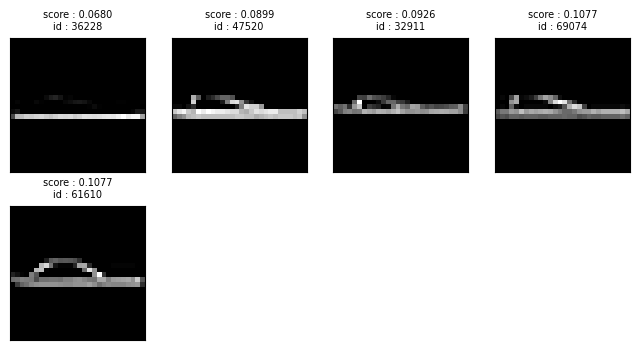

----------------------- dark images ------------------------

Number of examples with this issue: 23
Examples representing most severe instances of this issue:



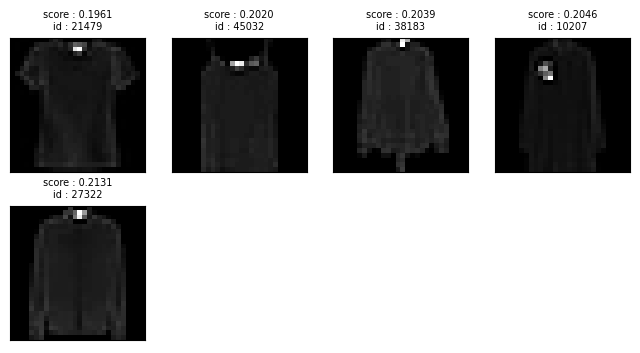

In [13]:
lab.report(include_description=False)

## Visualizing issues

### 1. Label issues

In [15]:
label_issues = lab.get_issues("label")
label_issues_df = label_issues[label_issues["is_label_issue"] == True].sort_values("label_score")
label_issues_df.head()

,is_label_issue,label_score,given_label,predicted_label
54312,True,8.797597e-07,T - shirt / top,Bag
11285,True,6.373388e-06,Coat,T - shirt / top
32021,True,1.184219e-05,Shirt,Coat
785,True,1.277412e-05,T - shirt / top,Bag
35959,True,1.316811e-05,Coat,Bag


In [16]:
import matplotlib.pyplot as plt

In [17]:
def plot_label_issue_examples(label_issues_df, nrows=1, ncols=1):
    count = 0
    for idx, row in label_issues_df.iterrows():
        plt.subplot(nrows, ncols, count + 1)
        plt.imshow(dataset[idx]["image"], cmap="gray")
        plt.title(
            f"id: {idx}\n GL: {row['given_label']}\n SL: {row['predicted_label']}",
            fontdict={"fontsize": 8},
        )
        plt.axis("off")
        count += 1
        if count >= nrows * ncols:
            break

    plt.tight_layout(h_pad=2.0)

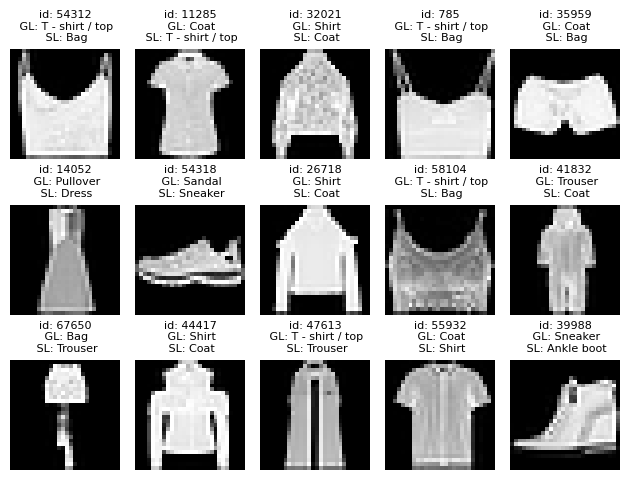

In [18]:
plot_label_issue_examples(label_issues_df, 3, 5)

In [19]:
outlier_issues_df = lab.get_issues("outlier")
outlier_issues_df = outlier_issues_df[outlier_issues_df["is_outlier_issue"] == True].sort_values(
    "outlier_score"
)
outlier_issues_df.head()

,is_outlier_issue,outlier_score
6808,True,0.744982
35798,True,0.748141
47319,True,0.781812
12755,True,0.785359
46998,True,0.785708


In [20]:
def plot_outlier_issues(outlier_issues_df, nrows=3, ncols=3):
    label_issues = lab.get_issues("label")
    N_comparison_images = 3

    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = (
            label_issues.join(outlier_issues_df)
            .query("given_label == @label and is_outlier_issue.isnull()")
            .index
        )
        non_outlier_indices_excluding_current = non_outlier_indices[non_outlier_indices != index]

        sampled_indices = np.random.choice(
            non_outlier_indices_excluding_current, number_of_samples, replace=False
        )

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][:N_comparison_images]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset[int(i)]["image"] for i in top_label_indices]

        return sampled_images

    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset[idx]["image"]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[:N_comparison_images]

        return image_from_dataset, corresponding_label, comparison_images

    for idx, row in outlier_issues_df.iterrows():
        idx = row.name
        image, label, comparison_images = get_image_given_label_and_samples(idx)
        image_to_plot = [image] + comparison_images
        fig, axes = plt.subplots(nrows=1, ncols=len(image_to_plot))
        for i, ax in enumerate(axes):
            if i == 0:
                ax.set_title(f"id: {idx}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(image_to_plot[i], cmap="gray")
            ax.axis("off")

    plt.show()

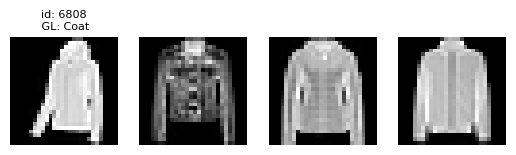

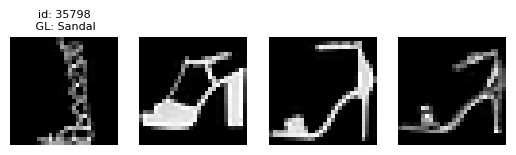

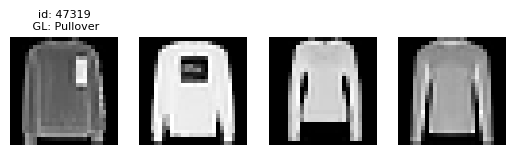

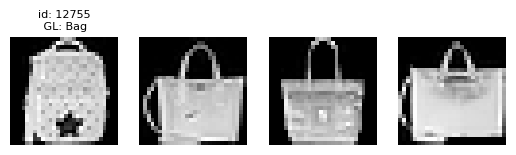

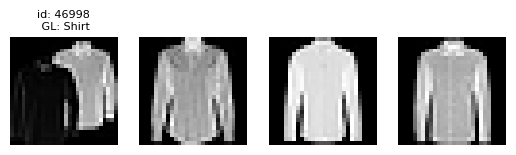

In [21]:
plot_outlier_issues(outlier_issues_df.head(5), nrows=1)

In [22]:
near_duplicate_issues_df = lab.get_issues("near_duplicate")
near_duplicate_issues_df = near_duplicate_issues_df[
    near_duplicate_issues_df["is_near_duplicate_issue"] == True
].sort_values("near_duplicate_score")
near_duplicate_issues_df.head()

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
23579,True,0.000001,"[33068, 30402, 31528, 24620, 27035, 38617, 307...",0.000001
33068,True,0.000001,"[23579, 30402, 31528, 24620, 34926, 27035]",0.000001
30402,True,0.000004,"[33068, 23579, 31528, 27035, 24620]",0.000004
31504,True,0.000026,[40563],0.000026
40563,True,0.000026,[31504],0.000026


In [35]:
seen_id_pairs = set()
label_issues = lab.get_issues("label")


def plot_label_and_near_duplicate_issues(near_duplicate_issues_df):
    def get_image_and_given_label_and_predicted_label(idx):
        image = dataset[idx]["image"]
        label = label_issues.loc[idx]["given_label"]
        predicted_label = label_issues.loc[idx]["predicted_label"]
        return image, label, predicted_label

    for idx, row in near_duplicate_issues_df.iterrows():
        image, label, predicted_label = get_image_and_given_label_and_predicted_label(idx)
        duplicate_images = row.near_duplicate_sets
        nd_set = set([int(i) for i in duplicate_images])
        nd_set.add(int(idx))

        if nd_set & seen_id_pairs:
            continue

        _, axes = plt.subplots(1, len(nd_set), figsize=(len(nd_set), 3))
        for i, ax in zip(list(nd_set), axes):
            label = label_issues.loc[i]["given_label"]
            ax.set_title(f"id: {i}\n GL: {label}", fontdict={"fontsize": 8})
            ax.imshow(dataset[i]["image"], cmap="gray")
            ax.axis("off")
        seen_id_pairs.update(nd_set)

        plt.show()

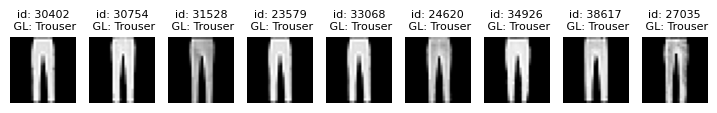

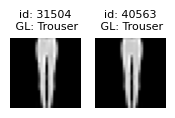

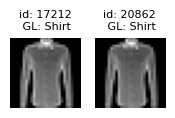

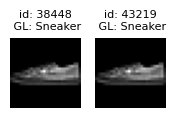

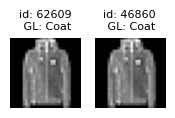

In [36]:
plot_label_and_near_duplicate_issues(near_duplicate_issues_df.head(10))